In [15]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import os
from ast import literal_eval
from gensim.models import KeyedVectors
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [38]:
### functions

sns.set(font_scale=1.1)

def evaluate_classifier(model, X_test, y_test, labels=None, label_encoder=None):
    labels = list(model.classes_)
    pred = model.predict(X_test) 
    if type(model['clf']) == XGBClassifier:
        pred = label_encoder.inverse_transform(pred)
        labels = label_encoder.inverse_transform(labels)
    fig, ax = plt.subplots(figsize=(8,6))
    # normalize : {'true', 'pred', 'all'}, default=None
    # Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. 
    # If None, confusion matrix will not be normalized.
    cm = confusion_matrix(y_test, pred, normalize=None) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax)
    plt.grid(False)
    plt.show()
    
    print("Accuracy  = " + str(accuracy_score(y_true=y_test, y_pred=pred)))
    print("F1 score  = " + str(f1_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Precision = " + str(precision_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Recall    = " + str(recall_score(y_true=y_test, y_pred=pred, average='weighted')))

In [17]:
df_train = pd.read_csv('../data/train_data.csv')
df_train['lemmatized'] = df_train['lemmatized'].apply(literal_eval)
df_train['tokenized'] = df_train['tokenized'].apply(literal_eval)

df_test = pd.read_csv('../data/test_data.csv')
df_test['lemmatized'] = df_test['lemmatized'].apply(literal_eval)
df_test['tokenized'] = df_test['tokenized'].apply(literal_eval)

df_train.head()

,filename,artist,title,genre,lyrics,instrumental,tokenized,lemmatized
0,country.00041.wav,Johnny Cash,Goin' By The Book,country,\nYou can see it in the movies and the paper a...,False,"[see, movies, paper, tv, news, somebodys, army...","[see, movie, paper, tv, news, somebody, army, ..."
1,reggae.00038.wav,Burning Spear,Investigation Dub,reggae,I and I old I know\nI and I old I say\nI and I...,False,"[old, know, old, say, reconsider, see, upfully...","[old, know, old, say, reconsider, see, upfully..."
2,disco.00070.wav,KC and The Sunshine Band,That's The Way (I Like It),disco,"That's the way, aha, aha\nI like it, aha, aha\...",False,"[thats, way, aha, aha, like, aha, aha, thats, ...","[thats, way, aha, aha, like, aha, aha, thats, ..."
3,reggae.00088.wav,Marcia Griffiths,Electric Boogie,reggae,\nIt's electric!\n\n\nYou can't see it\nIt's e...,False,"[electric, cant, see, electric, got, ta, feel,...","[electric, cant, see, electric, get, ta, feel,..."
4,pop.00017.wav,Britney Spears,(I Can't Get No) Satisfaction,pop,\nI can't get no satisfaction\nI can't get no ...,False,"[cant, get, satisfaction, cant, get, satisfact...","[cant, get, satisfaction, cant, get, satisfact..."


In [18]:
# word vectors of the following dimensions are available: 50d, 100d, 200d, 300d 
glove_path = '../glove/glove.6B.100d.txt'
glove_word2vec_path = glove_path + '.word2vec'

if os.path.exists(glove_word2vec_path):
    # load the Stanford GloVe model
    print("Loading saved glove word2vec model")
    glove_model = KeyedVectors.load_word2vec_format(glove_word2vec_path, binary=False)
else:
    # load the Stanford GloVe model from txt file, convert to word2vec and save
    glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)
    glove_model.save_word2vec_format(glove_word2vec_path)
    
print(glove_model)

Loading saved glove word2vec model


In [19]:
# Show a word embedding
print('King: ', glove_model.get_vector('king'))

# Show a similar word
similar_word = glove_model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print('Most similar word to King + Woman: ', similar_word)

King:  [-0.32307  -0.87616   0.21977   0.25268   0.22976   0.7388   -0.37954
 -0.35307  -0.84369  -1.1113   -0.30266   0.33178  -0.25113   0.30448
 -0.077491 -0.89815   0.092496 -1.1407   -0.58324   0.66869  -0.23122
 -0.95855   0.28262  -0.078848  0.75315   0.26584   0.3422   -0.33949
  0.95608   0.065641  0.45747   0.39835   0.57965   0.39267  -0.21851
  0.58795  -0.55999   0.63368  -0.043983 -0.68731  -0.37841   0.38026
  0.61641  -0.88269  -0.12346  -0.37928  -0.38318   0.23868   0.6685
 -0.43321  -0.11065   0.081723  1.1569    0.78958  -0.21223  -2.3211
 -0.67806   0.44561   0.65707   0.1045    0.46217   0.19912   0.25802
  0.057194  0.53443  -0.43133  -0.34311   0.59789  -0.58417   0.068995
  0.23944  -0.85181   0.30379  -0.34177  -0.25746  -0.031101 -0.16285
  0.45169  -0.91627   0.64521   0.73281  -0.22752   0.30226   0.044801
 -0.83741   0.55006  -0.52506  -1.7357    0.4751   -0.70487   0.056939
 -0.7132    0.089623  0.41394  -1.3363   -0.61915  -0.33089  -0.52881
  0.16483  -

In [20]:
## TODO: make into class that can be called in pipeline (see below)

class LyricsVectorizer:
    def __init__(self, model, method="mean"):
        print("Loading in word vectors...")
        self.word_vectors = model
        self.method = method
        print("Finished loading in word vectors")

    def fit(self, data):
        pass

    def transform(self, data):
        # determine the dimensionality of vectors
        self.D = self.word_vectors.vector_size

        X = np.zeros((len(data), self.D))
        n = 0
        
        if type(data[0]) == list:
            print("Data is tokenized")
            tokenized = True
        elif type(data[0]) == str:
            print("Data is non-tokenized string")
            tokenized = False
        else:
            print("Not recognized data type")
            return None
        
        for sentence in data:
            if tokenized:
                tokens = sentence
            else:
                tokens = sentence.split()
            vecs = []
            m = 0
            for word in tokens:
                try:
                    # throws KeyError if word not found
                    vec = self.word_vectors.get_vector(word)
                    vecs.append(vec)
                    m += 1
                except KeyError:
                    pass
            if len(vecs) > 0:
                vecs = np.array(vecs)
                if self.method == "mean":
                    X[n] = vecs.mean(axis=0) # lyrics embedding = mean over all words
                else:
                    X[n] = vecs.sum(axis=0) # lyrics embedding = sum over all words
                # maybe consider concatenation?
            n += 1
        return X

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [21]:
# Set a word vectorizer
vectorizer = LyricsVectorizer(glove_model)

# Get the sentence embeddings for the train dataset
X_train = vectorizer.fit_transform(df_train['lemmatized'])
y_train = df_train['genre']

# Get the sentence embeddings for the test dataset
X_test = vectorizer.transform(df_test['lemmatized'])
y_test = df_test['genre']

Loading in word vectors...
Finished loading in word vectors
Data is tokenized
Data is tokenized


## Classifier

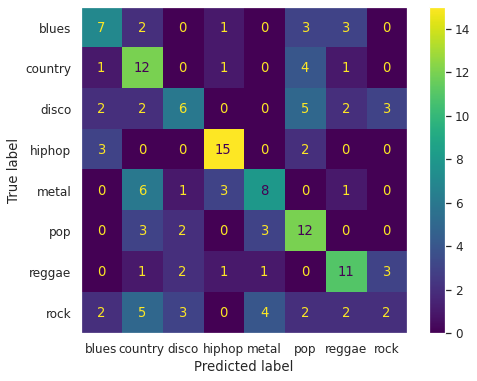

Accuracy  = 0.477124183006536
F1 score  = 0.45947439335486234
Precision = 0.46535997911709487
Recall    = 0.477124183006536


In [35]:
from sklearn.preprocessing import MinMaxScaler

pipe = Pipeline([('norm', MinMaxScaler()),
                 ('clf', SVC())])

pipe.fit(X_train, y_train)

evaluate_classifier(pipe, X_test, y_test)

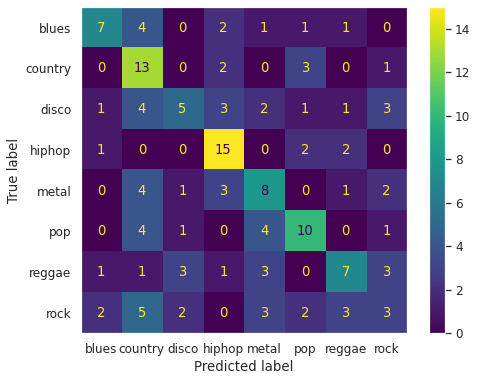

Accuracy  = 0.4444444444444444
F1 score  = 0.42979039028468174
Precision = 0.4412335514502697
Recall    = 0.4444444444444444


In [40]:
pipe = Pipeline([('norm', MinMaxScaler()),
                 ('clf', RandomForestClassifier())])

pipe.fit(X_train, y_train)

evaluate_classifier(pipe, X_test, y_test)

## from before

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class SentenceVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    # Vectorize a single sentence.
    def _transform(self, tokens):
        vec = np.zeros(nlp.vocab.vectors.shape[1])
        for token in tokens:
          vec = np.add(vec, nlp.vocab[token].vector)
        return vec

    def transform(self, X):
        return np.concatenate(
            [self._transform(row.tokenized).reshape(1, -1) for row in X.itertuples()]
            )

### Naive Bayes

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [ ]:
from sklearn.preprocessing import MinMaxScaler

pipe = Pipeline([('vectorizer', SentenceVectorizer()), 
                 ('Normalizing',MinMaxScaler()),
                 ('classifier', MultinomialNB())])
pipe.fit(df_train, df_train['gender'])

Pipeline(steps=[('vectorizer', SentenceVectorizer()),
                ('Normalizing', MinMaxScaler()),
                ('classifier', MultinomialNB())])

In [ ]:
pred = pipe.predict(df_test)
print(classification_report(y_true=df_test['gender'], y_pred=pred))

              precision    recall  f1-score   support

      female       0.38      0.00      0.00     64391
        male       0.51      1.00      0.68     67312

    accuracy                           0.51    131703
   macro avg       0.45      0.50      0.34    131703
weighted avg       0.45      0.51      0.35    131703



Bad performance, only 51% accuracy (as good as guessing)
-> this could be because NaiveBayes has assumption that features are independent of each other. So by doing sentence embedding and adding up the features, this is not fulfilled? Or it's the normalization step that changes the data? (necessary because NaiveBayes can't take negative values)

### Save the models to the drive

In [ ]:
import pickle

#model1 = '/content/drive/MyDrive/Colab Notebooks/gender_prediction/models/NB_countVec.sav'
#pickle.dump(pipe, open(model1, 'wb'))

#model2 = '/content/drive/MyDrive/Colab Notebooks/gender_prediction/models/NB_tfIdf.sav'
#pickle.dump(pipe_tfidf, open(model2, 'wb'))

# load the models with pickle.load(open(filename, 'rb'))